In [26]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')
import pandas as pd
from scipy.optimize import curve_fit
import pylab as pl
import numpy as np
from itertools import cycle
import subprocess
from subprocess import Popen, PIPE
import os
%matplotlib inline

import getpass
import pandas as pd 
from datetime import datetime
import sys
import os
import time

def set_work_env():
    curr_username = getpass.getuser()
    if curr_username == 'segura':
        transport_data_path = '/Users/' + curr_username + '/Desktop/slac_codes/slacecodes/transport_model/data'
        %run '/Users/segura/Desktop/slac_codes/slacecodes/utilities.ipynb'
    else:
        transport_data_path = '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/transport_model/data'
        %run '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/utilities.ipynb'
    print("you are all set!")
    print("current environment username:")
    print(curr_username)
    return(transport_data_path)

def raleigh_range(beam_waist, wv_lambda):
    #change to mm
    wv_adjust = wv_lambda*(10**-6)
    wavelength_dependency = np.multiply(np.pi, np.square(beam_waist)) 
    return(np.divide(wavelength_dependency, wv_adjust))

def beam_waist(z, beam_waist_0, wv_lambda):
    #lambda is in nm, so it needs to be adjusted to mm 
    #call raleigh_range 
    curr_raleigh = raleigh_range(beam_waist_0, wv_lambda)
    z_ratio = np.divide(z,curr_raleigh)
    root_factor = np.sqrt(1 + np.square(z_ratio))
    return(np.multiply(beam_waist_0,root_factor))
    

def lens_waist_size(z, w0, wavelength, focal_length):
    #call raleigh range 
    curr_raleigh = raleigh_range(w0,wavelength)
    lens_factor = 1 - np.divide(z,focal_length)
    far_away_factor = np.divide(z,curr_raleigh)
    root = np.sqrt( np.square(lens_factor) + np.square(far_away_factor))
    return(np.multiply(w0, root))

def intensity(x,y,z,w_0,wv_lambda,i_0):
    wv_adjust = np.multiply(wv_lambda,10**-6) 
    
    beam_factor_amplitude = i_0*np.square(np.divide(w_0, beam_waist(z,w_0,wv_lambda)))
    
    x_component = -2*np.square(np.divide(x,beam_waist(z,w_0,wv_lambda)))
    y_component = -2*np.square(np.divide(y,beam_waist(z,w_0,wv_lambda)))
    
    ex = np.exp(x_component)
    ey = np.exp(y_component)
    
    total_i = beam_factor_amplitude*np.multiply(ex,ey)
    total_ix = np.multiply(beam_factor_amplitude,ex)
    total_iy = np.multiply(beam_factor_amplitude,ey)
    
    return(total_ix,total_iy, total_i)

def gaussian(x,const, mean,sigma):
    mean_factor = x - mean
    e_arg = np.exp(-np.divide( np.square(mean_factor), 2*np.square(sigma)))
    return(const*e_arg )

def fit_parameter_extractor(fit_func, data):
    #typically data is the list above, with the containers for each run
    #each container has the x and irradiance data (x,irradiance)
    #like this:
    # [data_1, data_2, ..., data_n]
    # [ (x_1,irr_1), (x_2,irr_2),...,(x_n, irr_n)]
    
    #containers
    sigma_arr = [] 
    mean_arr = []
    amp_arr = []
    err_const_arr = []
    err_mean_arr = []
    err_sigma_arr = []
    
    
    #iterate to the data
    for i in range(len(data)):
        #get the curve_fit method 
        popt, pcov = curve_fit(fit_func, data[i][0], data[i][1],maxfev = 1800)
        #enter the values for (sigma, mean, amplitude)
        
        amp_arr.insert(i, popt[0])
        mean_arr.insert(i,popt[1])
        sigma_arr.insert(i,popt[2])
        
        #enter error values (1-std error)
        errors = np.sqrt(np.diag(pcov))
        err_const_arr.insert(i, errors[0])
        err_mean_arr.insert(i,errors[1])
        err_sigma_arr.insert(i,errors[2])
        
    return(amp_arr, mean_arr, sigma_arr, err_const_arr, err_mean_arr, err_sigma_arr)

def data_parser(file_path):
    curr_data = pd.read_csv(file_path, delimiter = '\t', encoding='utf-16', skiprows=11)
    #get parameters 
    curr_x = curr_data['  X Coordinate']
    curr_i = curr_data['    Irradiance']
    return(curr_x,curr_i)

"""
def data_pathfiles_generator(curr_path):
    #to return the values 
    arr = []
    #dir_path= Popen(["ls", "-l"], stdout=PIPE, stderr=PIPE)
    process=  Popen(["ls"], cwd=curr_path,  stdout=PIPE, stderr=PIPE)
    process_stdout= process.communicate()[0].decode('utf-8').rstrip()
    file_extractor_pos = Popen(["pwd"], cwd = curr_path, stdout=PIPE, stderr=PIPE)
    file_extractor_pos_stdout= file_extractor_pos.communicate()[0].decode('utf-8').rstrip()
    for l in process.stdout:
        if '.csv' in str(l):
            arr.append(str(file_extractor_pos_stdout.decode('utf-8')).rstrip()+'/'+str(l.decode('utf-8').rstrip()))
    arr.reverse()
    exit()
    return (arr)
"""
def data_pathfiles_generator(curr_path):
    #to return the values 
    arr = []
    #dir_path= Popen(["ls", "-l"], stdout=PIPE, stderr=PIPE)
    process=  Popen(["ls"], cwd=curr_path, stdout=PIPE, stderr=PIPE)
    process_stdout = process.communicate()[0]

    files_arr = process_stdout.decode('utf-8').splitlines()
    file_extractor_pos = Popen(["pwd"],cwd = curr_path, stdout=PIPE, stderr=PIPE)
    
    file_extractor_pos_stdout= file_extractor_pos.communicate()[0].decode('utf-8').rstrip()
    for file in files_arr:
        if '.csv' in file:
            arr.append(file_extractor_pos_stdout+'/'+file)  
    return(arr)

def filename_generator(path):
    process =Popen(["ls"], cwd=path, stdout=PIPE, stderr=PIPE)
    #to return the values 
    arr = []
    process_stdout = process.communicate()[0].decode('utf-8').splitlines()
    for l in process_stdout:
        if '.csv' in str(l):
            arr.append(l.replace('.csv',''))
    return (arr)

def data_generator(path_list):
    empty_arr = []
    for i in range(len(path_list)):
        empty_arr.insert(i, data_parser(path_list[i]))
    return(empty_arr)
        
def plot_generator(data_arr, num_rows, num_cols, figx, figy,
                   top_adjust_val, label_fontsize, 
                   title_fontsize, tick_params_fontsize
                  ,labelx_string, labely_string, title_string, 
                    label_arr, filename):
    cycol = cycle('bgrcmk')
    fig = plt.figure(figsize=(figx,figy))
    
    for pos in range(len(data_arr)):    
        axes = fig.add_subplot(num_rows, num_cols, pos+1)
        axes.plot(data_arr[pos][0], data_arr[pos][1], c = next(cycol), linestyle = '-.', label = str(label_arr[pos]).format('utf-8'))
        axes.tick_params(axis='both',labelsize=label_fontsize)
        axes.legend(fontsize =label_fontsize)
        axes.set_xlabel(str(labelx_string), fontsize=label_fontsize)
        axes.set_ylabel(str(labely_string), fontsize=label_fontsize)
        axes.tick_params(axis='both',labelsize=tick_params_fontsize)
        axes.legend(loc = 'upper right', fontsize=label_fontsize)
    
    fig.suptitle(title_string, fontsize=title_fontsize+5)
    fig.tight_layout()
    fig.subplots_adjust(top=top_adjust_val)
    fig.savefig(filename+'.jpg', dp1=1600)
   

In [1]:
cpath_5mm= Popen(['pwd'],
cwd= '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/fromfocallength' 
            ,stdout=PIPE, stderr=PIPE).communicate()[0].decode('utf-8').rstrip()


paths = data_pathfiles_generator(cpath_5mm)
m_paths = []
l_paths = []
l1_pdrifts = []
l2_pdrifts =[]
gallery_pdrifts =[]
m4l3_pdrifts = []
iptable_pdrifts =[]
l4comp_pdrifts =[]
ancillary = []
for i in data_paths:
    if 'mirror' in i:
        m_paths.append(i)
    if '/lens' in i and 'drift' not in i:
        l_paths.append(i)
    if 'lens1' in i and 'drift' in i:
        l1_pdrifts.append(i)
    if 'lens2' in i and 'drift' in i:
        l2_pdrifts.append(i)
    if 'gallery' in i:
        gallery_pdrifts.append(i)
    if 'm4l3' in i:
        m4l3_pdrifts.append(i)
    if 'iptable' in i:
        iptable_pdrifts.append(i)
    if 'l4comp' in i:
        l4comp_pdrifts.append(i)
    else:
        ancillary.append(i)
#generate datasets 

m_paths_d = data_generator(m_paths)

l_paths_d = data_generator(l_paths)
l1_pdrifts_d = data_generator(l1_pdrifts)
l2_pdrifts_d = data_generator(l2_pdrifts)
gallery_pdrifts_d = data_generator(gallery_pdrifts)
m4l3_pdrifts_d = data_generator(m4l3_pdrifts)
iptable_pdrifts_d =data_generator(iptable_pdrifts)
l4comp_pdrifts_d = data_generator(l4comp_pdrifts)
        
        
#generate waist data 

mwaists = np.multiply(2, fit_parameter_extractor(gaussian, m_paths_d)[2])
lwaists = np.multiply(2, fit_parameter_extractor(gaussian, l_paths_d)[2])
l1driftswaists =np.multiply(2, fit_parameter_extractor(gaussian, l1_pdrifts_d)[2])
l2driftswaists =np.multiply(2, fit_parameter_extractor(gaussian, l2_pdrifts_d)[2])
gallerywaists= np.multiply(2, fit_parameter_extractor(gaussian, gallery_pdrifts_d )[2])
m4l3waists= np.multiply(2, fit_parameter_extractor(gaussian, m4l3_pdrifts_d )[2])
iptablewaists = np.multiply(2, fit_parameter_extractor(gaussian, iptable_pdrifts_d )[2])
l4compdriftswaists= np.multiply(2, fit_parameter_extractor(gaussian, l4comp_pdrifts_d )[2])



m_paths_l = []
l_paths_l = []
l1_pdrifts_l = []
l2_pdrifts_l =[]
gallery_pdrifts_l =[]
m4l3_pdrifts_l = []
iptable_pdrifts_l =[]
l4comp_pdrifts_l =[]
ancillary_l = []
for i in f:
    if 'mirror' in i:
        m_paths_l.append(i)
    elif 'lens' in i and 'drift' not in i:
            l_paths_l.append(i)
    elif 'lens1' in i and 'drift' in i:
        l1_pdrifts_l.append(i)
    elif 'lens2' in i and 'drift' in i:
        l2_pdrifts_l.append(i)
    elif 'gallery' in i:
        gallery_pdrifts_l.append(i)
    elif 'm4l3' in i:
        m4l3_pdrifts_l.append(i)
    elif 'iptable' in i:
        iptable_pdrifts_l.append(i)
    elif 'l4comp' in i:
        l4comp_pdrifts_l.append(i)
    else:
        ancillary_l.append(i)

index_pos = []
t_map = []
t_map_pos = []
t_waist = []
#the transport:



t_map.append(m_paths_l[0])
t_map_pos.append(0)
t_map.append(l_paths_l[0])
t_map_pos.append(27)

for i in l1_pdrifts_l:
    t_map.append(i)

for i in range(544, 2612, 517):
    t_map_pos.append(i)

t_map.append(m_paths_l[1])
t_map_pos.append(2095)
t_map.append(l_paths_l[1])
t_map_pos.append(2195)


for i in l2_pdrifts_l:
    t_map.append(i)

t = np.arange(2965.5, 5280, 770.5)
for i in t:
    t_map_pos.append(i)

t_map.append(m_paths_l[2])
t_map_pos.append(5277)

t = np.arange(6501.2,11400,1224.2)
for i in t:
    t_map_pos.append(i)
t_map_pos.append(11398)

for i in gallery_pdrifts_l:
    t_map.append(i)

t = np.arange(11800.46, 13410.3, 402.460)
for i in t:
    t_map_pos.append(i)

t_map_pos.append(13410.3)
t_map_pos.append(13792) 

t_map.append(m_paths_l[3])

t = np.arange(16139.66, 25531.3, 2347.660)
for i in t:
    t_map_pos.append(i)
t_map_pos.append(25530.3)

for i in m4l3_pdrifts_l:
    t_map.append(i)

t_map.append(l_paths_l[2])
t_map.append(m_paths_l[4])

for i in iptable_pdrifts_l:
    t_map.append(i)

t_map.append(m_paths_l[5])
t_map.append(l_paths_l[3])

for i in l4comp_pdrifts_l:
    t_map.append(i)

t_map_pos.append(25912)
    
t = np.arange(26290, 27803,378)
for i in t:
    t_map_pos.append(i)

t_map_pos.append(27802)

for i in ancillary:
    t_map.append(i)
####
for i in range(len(t_map_pos)):
    index_pos.append(i)

for i in range(len(t_map_pos)):
    print(index_pos[i], t_map[i], t_map_pos[i] )
        
mirrors_data = data_generator(m_paths)
lenses_data = data_generator(l_paths)
l1_drifts = data_generator(l1_pdrifts)
l2_drifts = data_generator(l2_pdrifts)
gallert_drifts = data_generator(gallery_pdrifts)
m4l3_drifts = data_generator(m4l3_pdrifts)
iptable_drifts = data_generator(iptable_pdrifts)
l4comp_drifts = data_generator(l4comp_pdrifts)



NameError: name 'Popen' is not defined

In [37]:
cpath= Popen(['pwd'], cwd= '/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/from_mirror_prop_5mm' ,stdout=PIPE, stderr=PIPE).communicate()[0].decode('utf-8').rstrip()

f = filename_generator(cpath)
print(cpath)
data_paths = data_pathfiles_generator(cpath)

#print(data_paths)
m_paths = []
l_paths = []
l1_pdrifts = []
l2_pdrifts =[]
gallery_pdrifts =[]
m4l3_pdrifts = []
iptable_pdrifts =[]
l4comp_pdrifts =[]
ancillary = []
for i in data_paths:
    if 'mirror' in i:
        m_paths.append(i)
    if '/lens' in i and 'drift' not in i:
        l_paths.append(i)
    if 'lens1' in i and 'drift' in i:
        l1_pdrifts.append(i)
    if 'lens2' in i and 'drift' in i:
        l2_pdrifts.append(i)
    if 'gallery' in i:
        gallery_pdrifts.append(i)
    if 'm4l3' in i:
        m4l3_pdrifts.append(i)
    if 'iptable' in i:
        iptable_pdrifts.append(i)
    if 'l4comp' in i:
        l4comp_pdrifts.append(i)
    else:
        ancillary.append(i)
#generate datasets 

m_paths_d = data_generator(m_paths)

l_paths_d = data_generator(l_paths)
l1_pdrifts_d = data_generator(l1_pdrifts)
l2_pdrifts_d = data_generator(l2_pdrifts)
gallery_pdrifts_d = data_generator(gallery_pdrifts)
m4l3_pdrifts_d = data_generator(m4l3_pdrifts)
iptable_pdrifts_d =data_generator(iptable_pdrifts)
l4comp_pdrifts_d = data_generator(l4comp_pdrifts)
        
        
#generate waist data 

mwaists = np.multiply(2, fit_parameter_extractor(gaussian, m_paths_d)[2])
lwaists = np.multiply(2, fit_parameter_extractor(gaussian, l_paths_d)[2])
l1driftswaists =np.multiply(2, fit_parameter_extractor(gaussian, l1_pdrifts_d)[2])
l2driftswaists =np.multiply(2, fit_parameter_extractor(gaussian, l2_pdrifts_d)[2])
gallerywaists= np.multiply(2, fit_parameter_extractor(gaussian, gallery_pdrifts_d )[2])
m4l3waists= np.multiply(2, fit_parameter_extractor(gaussian, m4l3_pdrifts_d )[2])
iptablewaists = np.multiply(2, fit_parameter_extractor(gaussian, iptable_pdrifts_d )[2])
l4compdriftswaists= np.multiply(2, fit_parameter_extractor(gaussian, l4comp_pdrifts_d )[2])



m_paths_l = []
l_paths_l = []
l1_pdrifts_l = []
l2_pdrifts_l =[]
gallery_pdrifts_l =[]
m4l3_pdrifts_l = []
iptable_pdrifts_l =[]
l4comp_pdrifts_l =[]
ancillary_l = []
for i in f:
    if 'mirror' in i:
        m_paths_l.append(i)
    elif 'lens' in i and 'drift' not in i:
            l_paths_l.append(i)
    elif 'lens1' in i and 'drift' in i:
        l1_pdrifts_l.append(i)
    elif 'lens2' in i and 'drift' in i:
        l2_pdrifts_l.append(i)
    elif 'gallery' in i:
        gallery_pdrifts_l.append(i)
    elif 'm4l3' in i:
        m4l3_pdrifts_l.append(i)
    elif 'iptable' in i:
        iptable_pdrifts_l.append(i)
    elif 'l4comp' in i:
        l4comp_pdrifts_l.append(i)
    else:
        ancillary_l.append(i)

index_pos = []
t_map = []
t_map_pos = []
t_waist = []
#the transport:



t_map.append(m_paths_l[0])
t_map_pos.append(0)
t_map.append(l_paths_l[0])
t_map_pos.append(27)

for i in l1_pdrifts_l:
    t_map.append(i)

for i in range(544, 2612, 517):
    t_map_pos.append(i)

t_map.append(m_paths_l[1])
t_map_pos.append(2095)
t_map.append(l_paths_l[1])
t_map_pos.append(2195)


for i in l2_pdrifts_l:
    t_map.append(i)

t = np.arange(2965.5, 5280, 770.5)
for i in t:
    t_map_pos.append(i)

t_map.append(m_paths_l[2])
t_map_pos.append(5277)

t = np.arange(6501.2,11400,1224.2)
for i in t:
    t_map_pos.append(i)
t_map_pos.append(11398)

for i in gallery_pdrifts_l:
    t_map.append(i)

t = np.arange(11800.46, 13410.3, 402.460)
for i in t:
    t_map_pos.append(i)

t_map_pos.append(13410.3)
t_map_pos.append(13792) 

t_map.append(m_paths_l[3])

t = np.arange(16139.66, 25531.3, 2347.660)
for i in t:
    t_map_pos.append(i)
t_map_pos.append(25530.3)

for i in m4l3_pdrifts_l:
    t_map.append(i)

t_map.append(l_paths_l[2])
t_map.append(m_paths_l[4])

for i in iptable_pdrifts_l:
    t_map.append(i)

t_map.append(m_paths_l[5])
t_map.append(l_paths_l[3])

for i in l4comp_pdrifts_l:
    t_map.append(i)

t_map_pos.append(25912)
    
t = np.arange(26290, 27803,378)
for i in t:
    t_map_pos.append(i)

t_map_pos.append(27802)

for i in ancillary:
    t_map.append(i)
####
for i in range(len(t_map_pos)):
    index_pos.append(i)

for i in range(len(t_map_pos)):
    print(index_pos[i], t_map[i], t_map_pos[i] )
        
mirrors_data = data_generator(m_paths)
lenses_data = data_generator(l_paths)
l1_drifts = data_generator(l1_pdrifts)
l2_drifts = data_generator(l2_pdrifts)
gallert_drifts = data_generator(gallery_pdrifts)
m4l3_drifts = data_generator(m4l3_pdrifts)
iptable_drifts = data_generator(iptable_pdrifts)
l4comp_drifts = data_generator(l4comp_pdrifts)




/Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/from_mirror_prop_5mm


/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


0 mirror1 0
1 lens1 27
2 drift1lens1 544
3 drift2lens1 1061
4 drift3lens1 1578
5 drift4lens1 2095
6 mirror2 2095
7 lens2 2195
8 drift1lens2 2965.5
9 drift2lens2 3736.0
10 drift3lens2 4506.5
11 drift4lens2 5277.0
12 mirror3 5277
13 drift1insidegallery 6501.2
14 drift2insidegallery 7725.4
15 drift3insidegallery 8949.6
16 drift4insidegallery 10173.8
17 drift5insidegallery 11398.0
18 mirror4 11398
19 drift1m4l3 11800.46
20 drift2m4l3 12202.92
21 drift3m4l3 12605.38
22 drift4m4l3 13007.84
23 drift5m4l3 13410.3
24 lens3 13410.3
25 mirror5 13792
26 drift1iptable 16139.66
27 drift2iptable 18487.32
28 drift3iptable 20834.98
29 drift4iptable 23182.64
30 drift5iptable 25530.3
31 mirror6 25530.3
32 lens4 25912
33 drift1l4comp 26290
34 drift2l4comp 26668
35 drift3l4comp 27046
36 drift4l4comp 27424
37 drift5l4comp 27802
38 /Users/eseguraca.6/Desktop/SLACfiles/slacecodes/FACET_model_current/curr_build/from_mirror_prop_5mm/compressor.csv 27802


In [33]:
print("magnification:", (lwaists[1]/lwaists[0]))
anc = data_generator(ancillary)
comp = np.multiply(2, fit_parameter_extractor(gaussian, anc)[2])

mwaistl_l = mwaists.tolist()
lwaist_l = lwaists.tolist() 
l1driftswaists_l = l1driftswaists.tolist()
l2driftswaists_l = l2driftswaists.tolist()
gallerywaists_l = gallerywaists.tolist()
m4l3waists_l = m4l3waists.tolist()
iptablewaists_l = iptablewaists.tolist() 
l4compdriftswaists_l = l4compdriftswaists.tolist() 

twaists = []
twaists.append(mwaistl_l[0])
twaists.append(lwaist_l[0])

for i in l1driftswaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[1])
twaists.append(lwaist_l[1])
 

for i in l2driftswaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[2])

for i in gallerywaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[3])

for i in m4l3waists_l:
    twaists.append(i)
    
twaists.append(lwaist_l[2])
twaists.append(mwaistl_l[4])

for i in iptablewaists_l:
    twaists.append(i)

twaists.append(mwaistl_l[5])
twaists.append(lwaist_l[3])  

for i in l4compdriftswaists_l:
    twaists.append(i)
twaists.append(comp[0])

for i in range(len(t_map_pos)):
    print(index_pos[i], twaists[i], t_map_pos[i] )

magnification: 2.64034071256
0 12.37858050429918 0
1 4.982878062552756 27
2 -0.45181924498721887 544
3 4.080289492477601 1061
4 8.611788684940095 1578
5 13.143310038331244 2095
6 15.507533612191152 2095
7 13.156495814274056 2195
8 13.577145221921844 2965.5
9 13.997802003504658 3736.0
10 14.418466361906292 4506.5
11 14.839140139561831 5277.0
12 13.256977930534108 5277
13 15.507533612191152 6501.2
14 16.17594330729491 7725.4
15 16.844365028146584 8949.6
16 17.512799850024663 10173.8
17 18.181244957489607 11398.0
18 11.13328505019648 11398
19 18.400996169835455 11800.46
20 18.62075838442431 12202.92
21 18.8405155047787 12605.38
22 19.060272052890884 13007.84
23 19.280031681915993 13410.3
24 19.275787873273323 13410.3
25 -0.45181924498721887 13792
26 13.256977930534108 16139.66
27 7.238280311067689 18487.32
28 1.2213461324495765 20834.98
29 4.800439347955476 23182.64
30 10.818955312276104 25530.3
31 13.577145221921844 25530.3
32 10.82398979456753 25912
33 11.13328505019648 26290
34 11.4425

/anaconda/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


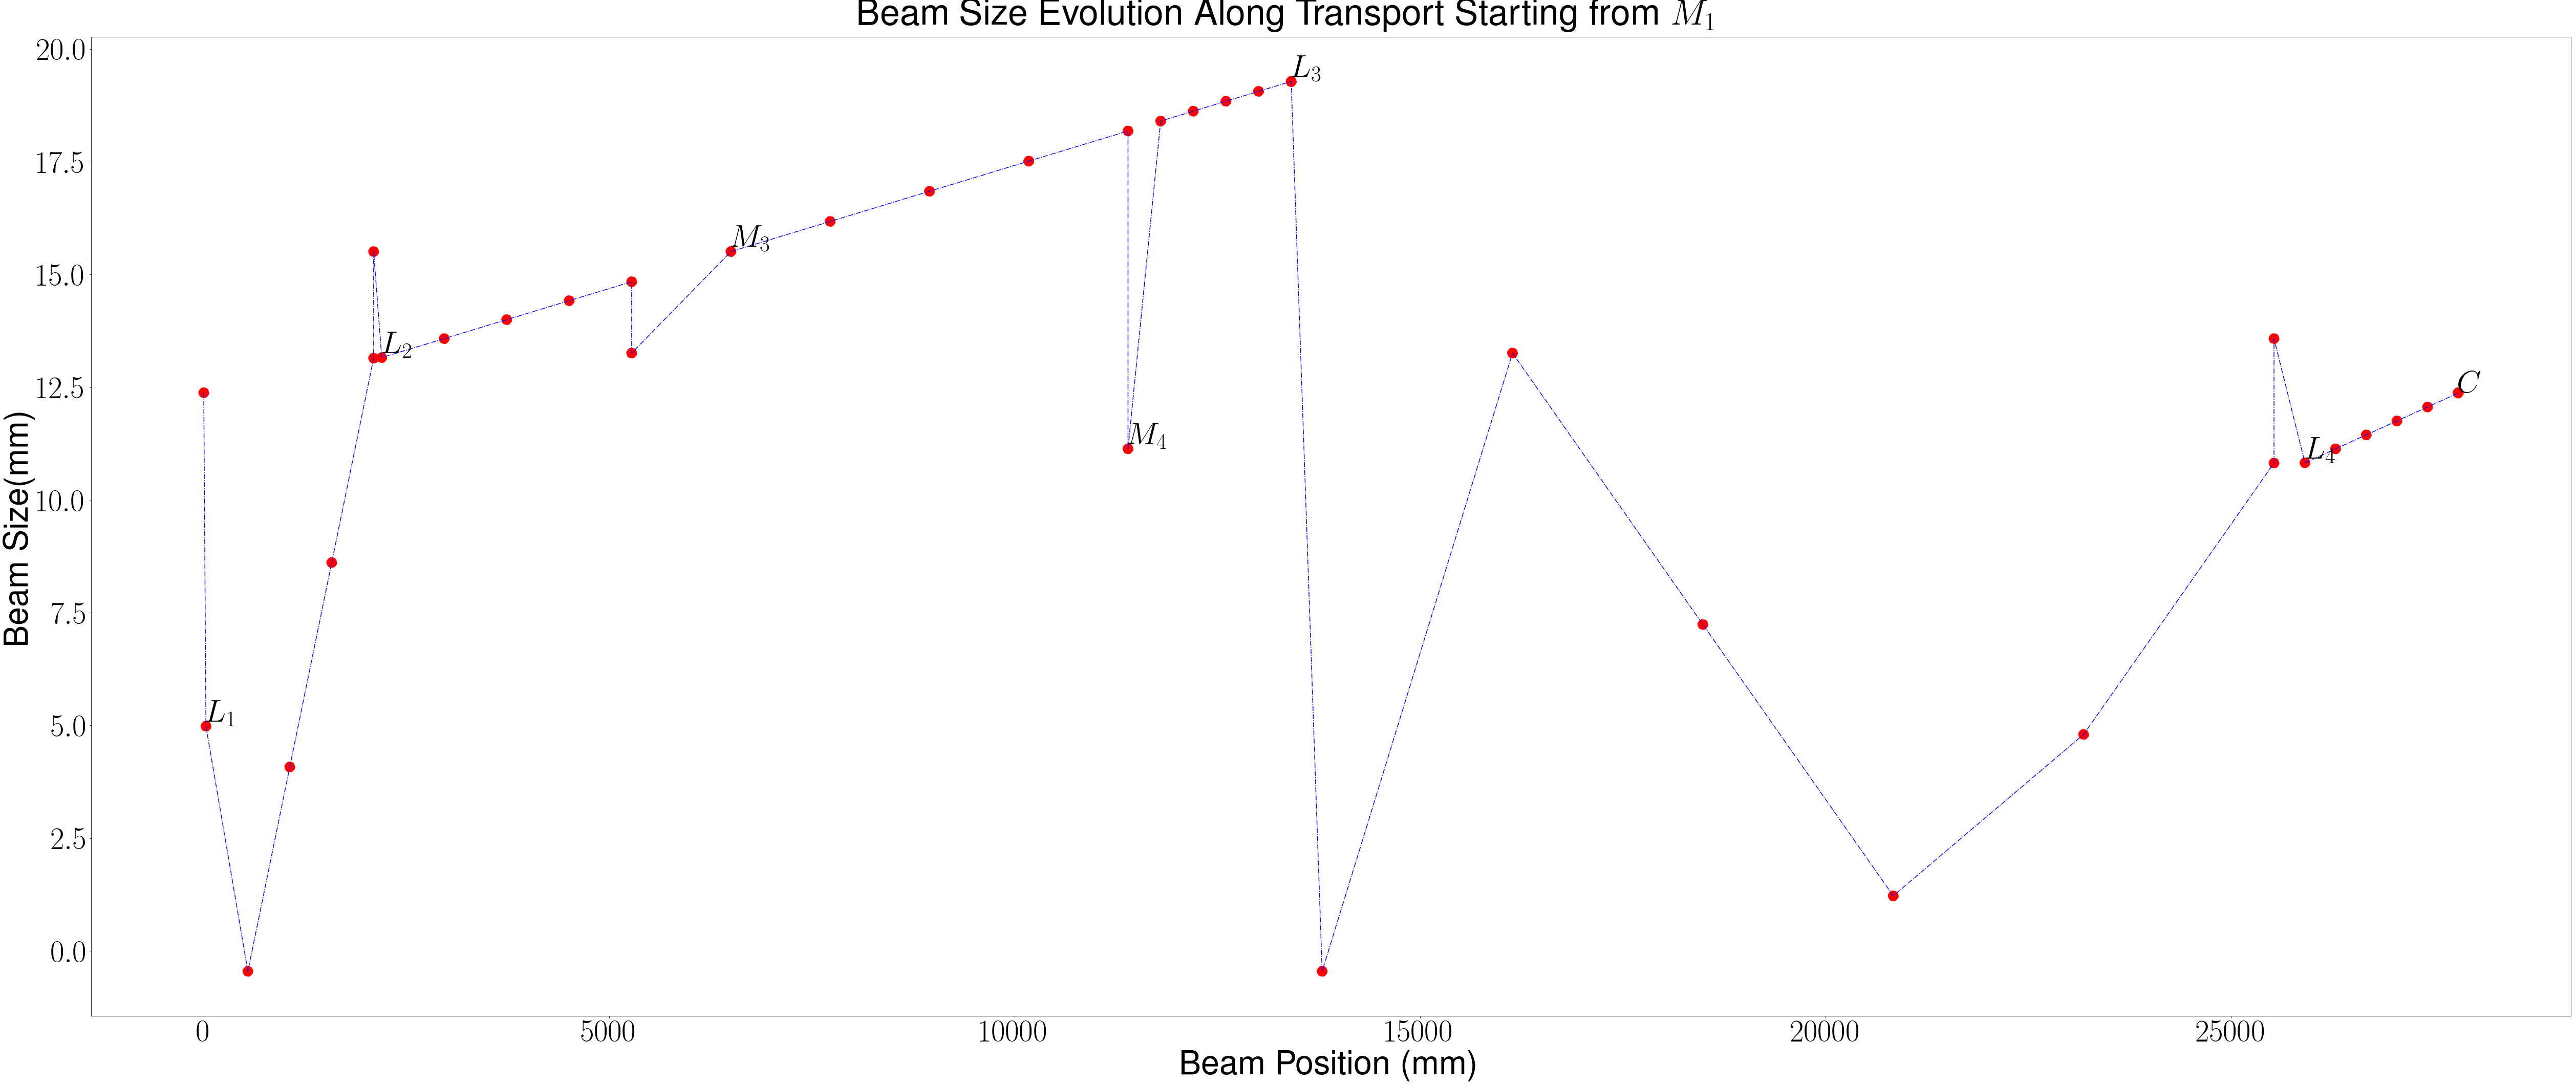

In [34]:
labels =['$L_1$', 
          
            '$L_2$', 
         
         '$M_3$', 
         
         '$M_4$', 
         
         '$L_3$', 
         
         '$L_4$', 
         
         '$C$']
x = t_map_pos
y = twaists
cycol = cycle('bgrcmk')
fig = plt.figure(figsize=(70,30))
axes = fig.add_subplot(1, 1, 1)
axes.scatter(x, y, color = 'red', linestyle = '-.', s=400)
axes.plot(x,y, c=next(cycol), linestyle = '-.')
axes.tick_params(axis='both',labelsize=55)
axes.legend(fontsize =55)
axes.set_xlabel(str('Beam Position (mm)'), fontsize=55+10)
axes.set_ylabel(str('Beam Size(mm)'), fontsize=55+10)
axes.tick_params(axis='both',labelsize=55+5)
axes.legend(loc = 'upper right', fontsize=55)
fig.suptitle('Beam Size Evolution Along Transport Starting from $M_1$', fontsize=55+15)
fig.tight_layout()
fig.subplots_adjust(top=0.95)



xp = [x[1], x[7] ,x[13],  x[18],x[24],x[32], x[38]]
yp = [y[1], y[7], y[13], y[18],y[24],y[32], y[38]]
for l, xpt, ypt in zip(labels, xp,yp):
    axes.text(xpt,ypt,l, fontsize=60+2)

#fig.savefig(cpath+ '/'+'frommirror' + "-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+'.jpg', dp1=1600)

In [ ]:
for i in range(len(y)):
        print(y[i], )

In [ ]:
cpath= Popen(['pwd'], stdout=PIPE, stderr=PIPE).communicate()[0].decode('utf-8').rstrip()

mag_files = [cpath+str('/1fblens1.csv'), cpath+str('/1falens1.csv'), cpath+str('/1falens2.csv')]

data_mag = data_generator(mag_files)

waist_mag = np.multiply(2, fit_parameter_extractor(gaussian, data_mag)[2])

print(waist_mag)

print("magnification:")
print((waist_mag[2]/waist_mag[0]))

In [ ]:
factor = raleigh_range(5,600)
print(factor/1000)